In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [3]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms
from avgn.visualization.spectrogram import draw_spec_set
from avgn.visualization.quickplots import draw_projection_plots

In [4]:
from soundsig.sound import BioSound 

### Collect data

In [5]:
DATASET_ID = 'BIRD_DB_Vireo_cassinii'

In [6]:
df_loc =  DATA_DIR / 'syllable_dfs' / DATASET_ID / 'cassins.pickle'
df_loc

PosixPath('/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/data/syllable_dfs/BIRD_DB_Vireo_cassinii/cassins.pickle')

In [7]:
syllable_df = pd.read_pickle(df_loc)

In [8]:
syllable_df["syll_len"] = syllable_df.end_time - syllable_df.start_time

In [9]:
len(syllable_df)

67032

In [10]:
syllable_df[:3]

,start_time,end_time,labels,indv,indvi,subject_importance,key,audio,rate,spectrogram,syll_len
0,9.842790,10.105938,ah,ORA,0,Primary subject,2014-05-29_10-10-00-000000,"[-0.19927763130383222, -0.2129138251615996, -0...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3059005, 0.4...",0.263149
1,72.031245,72.346332,ah,ORA,0,Primary subject,2014-05-29_10-10-00-000000,"[-0.12207342570633199, -0.09996911527363203, -...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.12574787, 0.12236...",0.315086
2,74.130176,74.376012,bz,ORA,0,Primary subject,2014-05-29_10-10-00-000000,"[-0.0889848557398444, -0.06770700742932487, -0...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2822944, 0.0...",0.245836


In [11]:
syllable_df['nsamp'] = [len(row.audio) for idx, row in tqdm(syllable_df.iterrows(), total=len(syllable_df))]

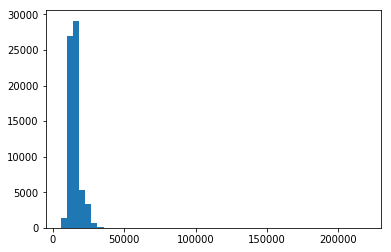

In [12]:
plt.hist(syllable_df['nsamp'].values, bins=50);

In [35]:
def create_Biosound(audio, rate, spec_sample_rate= 1000, freq_spacing = 100,):
    myBioSound = BioSound(soundWave=audio, fs=rate)
    # Calculate the spectrogram and the rms
    myBioSound.spectroCalc(spec_sample_rate=spec_sample_rate, freq_spacing = freq_spacing, min_freq=0, max_freq=10000)
    myBioSound.rms = myBioSound.sound.std() 

    # Calculate amplitude enveloppe
    myBioSound.ampenv(cutoff_freq = 20, amp_sample_rate = 500)

    # Calculate the power spectrum
    myBioSound.spectrum(f_high=15000)

    # Calculate fundamental and related values.  These are the default values.
    # For the estimation of the fundamental, four methods are available: 
    # 'AC' - Peak of the auto-correlation function
    # 'ACA' - Peak of envelope of auto-correlation function 
    # 'Cep' - First peak in cepstrum 
    # 'Stack' - Fitting of harmonic stacks (default - works well for zebra finches)

    myBioSound.fundest(maxFund = 10000, minFund = 500, lowFc = 200, highFc = 6000, 
                       minSaliency = 0.5, debugFig = 0, 
                       minFormantFreq = 500, maxFormantBW = 500, windowFormant = 0.1,
                       method='Stack')

    # Calculate the MPS
    myBioSound.mpsCalc(window=0.1, Norm = True)
    #myBioSound.plot(DBNOISE=50, f_low=250, f_high=10000)  
    
    return myBioSound

In [36]:
def create_BioSound_features(myBioSound):

    # try:
    if (myBioSound.fund is not None) and (type(myBioSound.fund) is
                                          np.float64):
        fund = np.float(myBioSound.fund)
        cvfund = np.float(myBioSound.cvfund)
        maxfund = np.float(myBioSound.maxfund)
        minfund = np.float(myBioSound.minfund)
    else:
        return

    # Take the time average formants
    meanF1 = np.mean(myBioSound.F1[~np.isnan(myBioSound.F1)])
    meanF2 = np.mean(myBioSound.F2[~np.isnan(myBioSound.F2)])
    meanF3 = np.mean(myBioSound.F3[~np.isnan(myBioSound.F3)])

    features = pd.DataFrame({
        "fund": [fund],  # Average fundamental
        "cvfund": [cvfund],  # np.std(goodFund)/meanfund
        "maxfund": [maxfund],  # maximum of fund
        "minfund": [minfund],  # maximum of fund
        "F1": [meanF1],  # time varying formant 1
        "F2": [meanF2],
        "F3": [meanF3],
        "sal": [np.float(myBioSound.meansal)],  # Average saliency
        "rms": [np.float(myBioSound.rms)],
        "maxAmp": [np.float(myBioSound.maxAmp)],
        "meanS": [np.float(myBioSound.meanspect)],  # mean of spectrogram
        "stdS": [np.float(myBioSound.stdspect)],  # std of spectrogram
        "skewS": [np.float(myBioSound.skewspect)],  # skew of spectrogram
        # kurtosis of spectrogram
        "kurtS": [np.float(myBioSound.kurtosisspect)],
        "entS": [np.float(myBioSound.entropyspect)],  # entropy of spectrogram
        # quartile 1 of frequency from power spectrum
        "q1": [np.float(myBioSound.q1)],
        "q2": [np.float(myBioSound.q2)],
        "q3": [np.float(myBioSound.q3)],
        "meanT": [np.float(myBioSound.meantime)],  # np.sum(tdata*ampdata)
        # amplitude envelope relative to time
        # np.sqrt(np.sum(ampdata*((tdata-meantime)**2)))
        "stdT": [np.float(myBioSound.stdtime)],
        # skewtime = np.sum(ampdata*(tdata-meantime)**3)  // skewtime = skewtime/(stdtime**3)
        "skewT": [np.float(myBioSound.skewtime)],
        # kurtosistime = np.sum(ampdata*(tdata-meantime)**4) // kurtosistime = kurtosistime/(stdtime**4)
        "kurtT": [np.float(myBioSound.kurtosistime)],
        # np.sum(ampdata[indpos]*np.log2(ampdata[indpos]))/np.log2(np.size(indpos))
        # indpos = np.where(ampdata>0)[0]
        # entropytime = -np.sum(ampdata[indpos]*np.log2(ampdata[indpos]))/np.log2(np.size(indpos))
        "entT": [np.float(myBioSound.entropytime)]
    })
    # except TypeError:
    #    return
    return features

In [41]:
from avgn.signalprocessing.filtering import butter_bandpass_filter

In [54]:
butter_lowcut = 2000; butter_highcut=10000
def get_BioSound_features(audio, rate):
    # pad if too short
    audio = np.pad(audio, 1050) if len(audio) < 1050 else audio
    
    audio = butter_bandpass_filter(
            audio, butter_lowcut, butter_highcut, rate, order=5
        )
    
    myBioSound = create_Biosound(audio, rate)
    if myBioSound is None:
        return
    features = create_BioSound_features(myBioSound)
    return features

In [57]:
import IPython.display as ipd

In [58]:
import noisereduce as nr

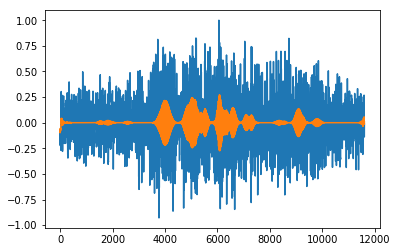

In [86]:
for idx, row in tqdm(syllable_df[:10].iterrows(), total=len(syllable_df)):
    break
audio = row.audio
nraudio = nr.reduce_noise(audio_clip=audio, n_std_thresh=2, win_length=512, n_fft = 512,hop_length=32, verbose=False)
plt.plot(audio)
plt.plot(nraudio)

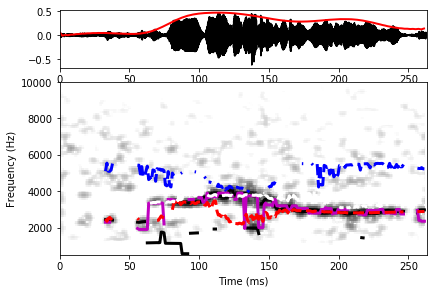

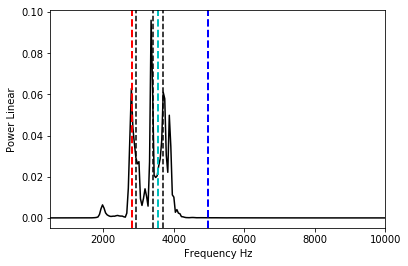

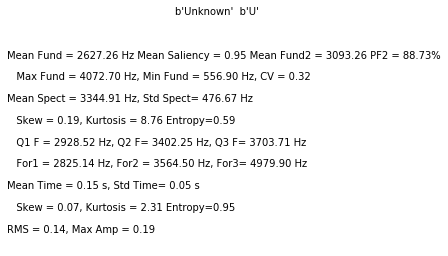

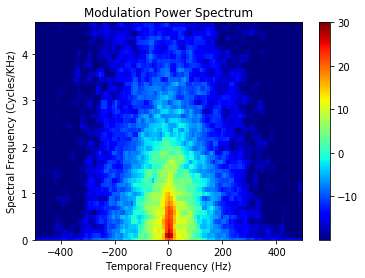

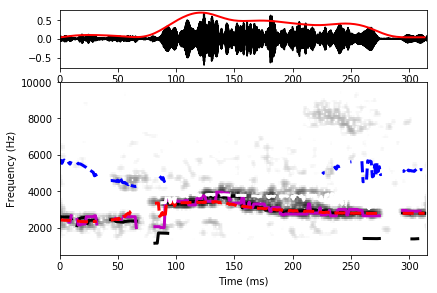

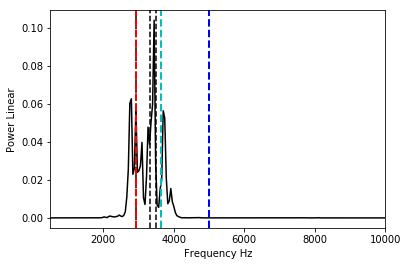

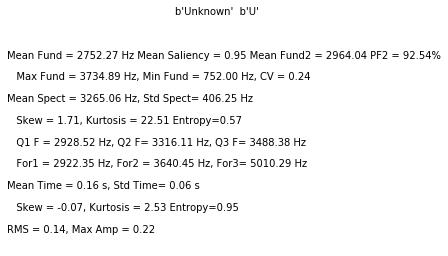

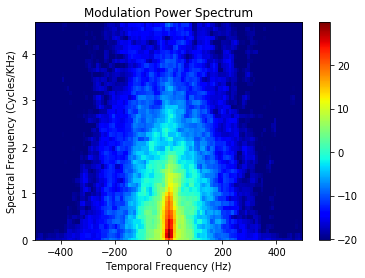

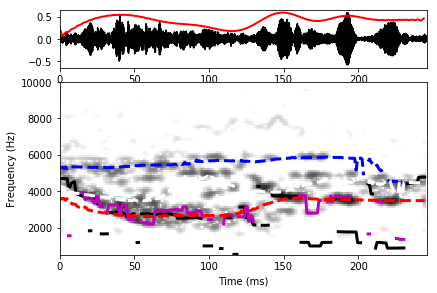

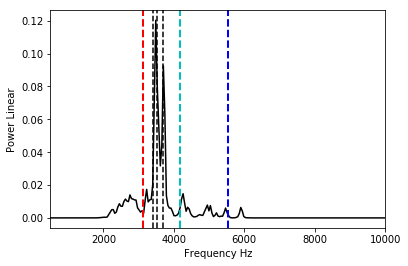

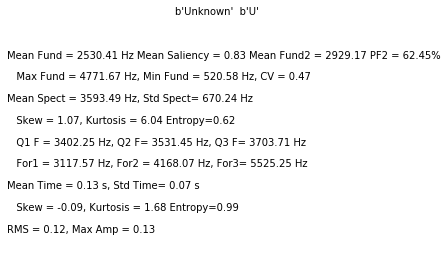

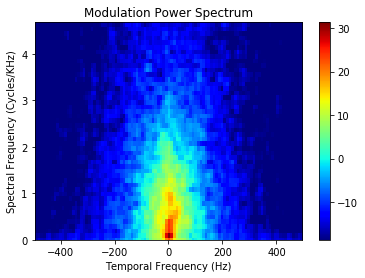

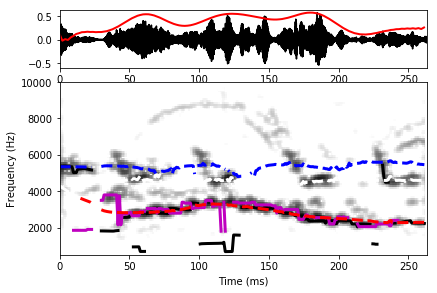

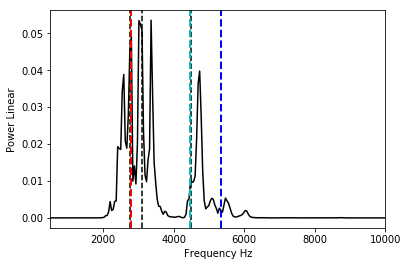

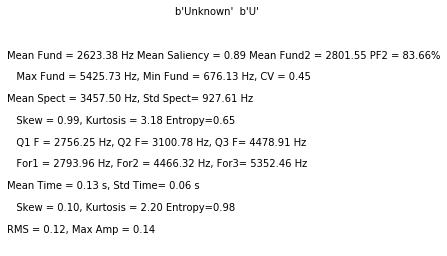

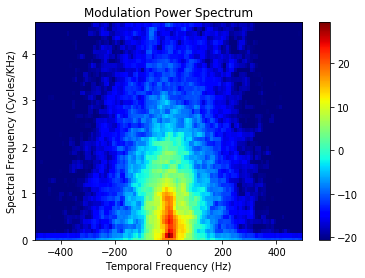

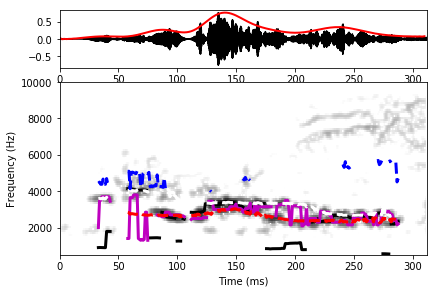

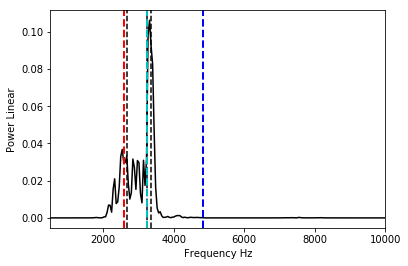

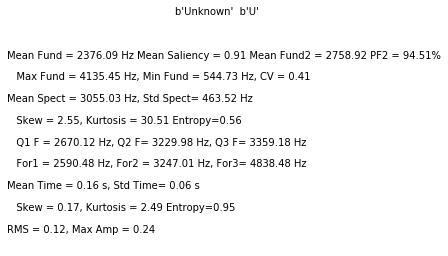

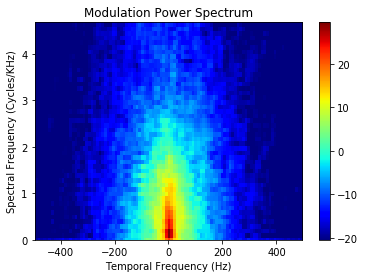

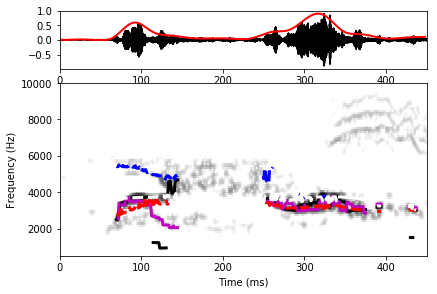

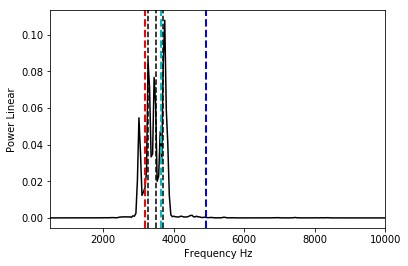

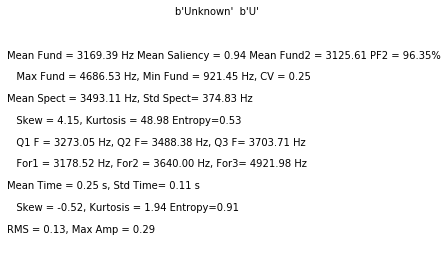

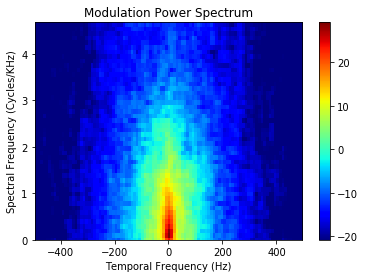

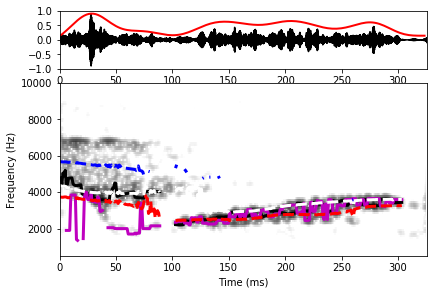

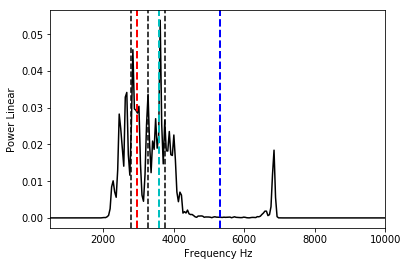

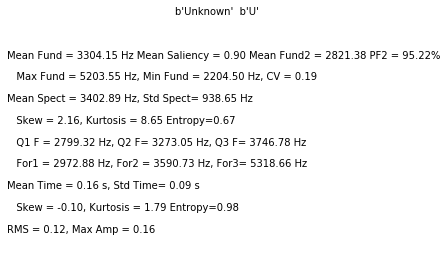

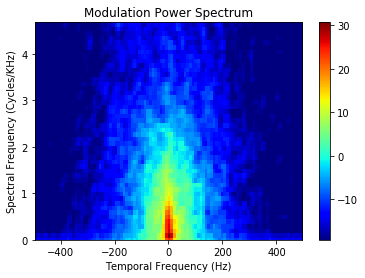

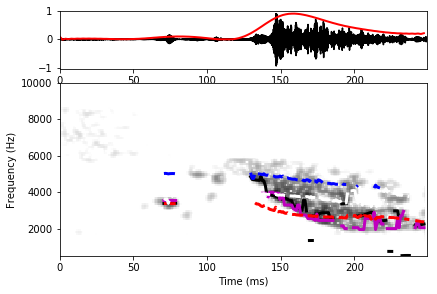

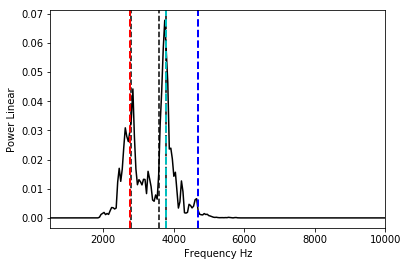

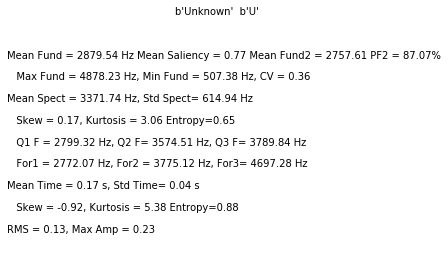

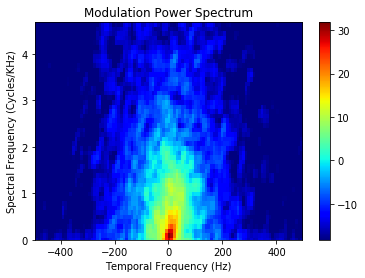

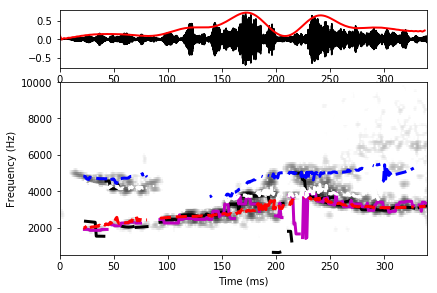

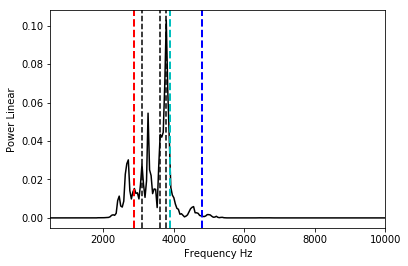

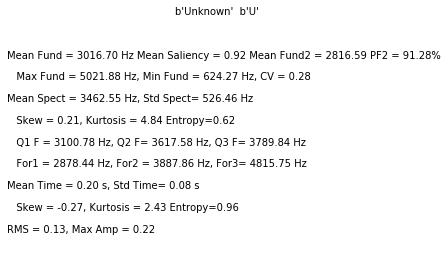

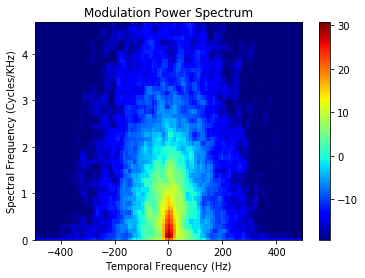

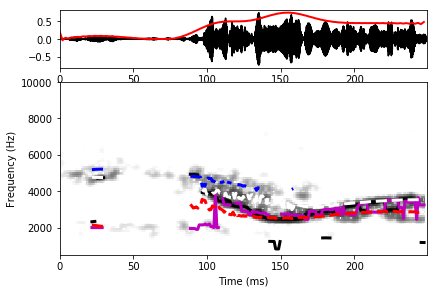

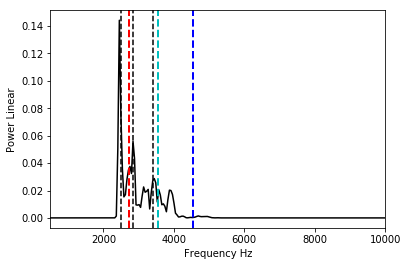

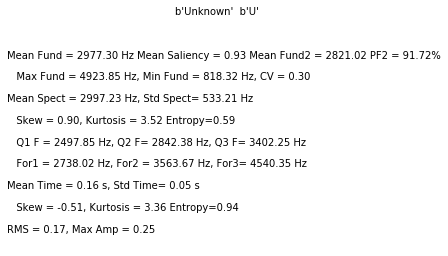

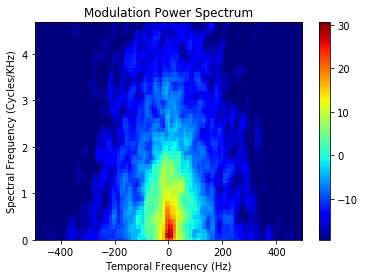

In [89]:
for idx, row in tqdm(syllable_df[:10].iterrows(), total=len(syllable_df)):
    audio = row.audio
    audio = nr.reduce_noise(
        audio_clip=audio,
        n_std_thresh=1,
        win_length=512,
        n_fft=512,
        hop_length=32,
        verbose=False)

    audio = butter_bandpass_filter(
        audio, butter_lowcut, butter_highcut, rate, order=5)
    rate = row.rate
    audio = np.pad(audio, 1050) if len(audio) < 1050 else audio
    myBioSound = create_Biosound(audio, rate)
    myBioSound.plot(DBNOISE=50, f_low=500, f_high=10000)
    plt.show()

In [ ]:
with Parallel(n_jobs=-1, verbose=10) as parallel:
    biosound_dfs = parallel(
        delayed(get_BioSound_features)(
            row.audio, row.rate
        )
        for idx, row in tqdm(syllable_df.iterrows(), total = len(syllable_df))
    )
mask = [i is not None for i in biosound_dfs]
biosound_df = pd.concat([i for i in biosound_dfs if i is not None], axis=0)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   44.4s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 117 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 249 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  

[Parallel(n_jobs=-1)]: Done 10018 tasks      | elapsed: 145.3min
[Parallel(n_jobs=-1)]: Done 10161 tasks      | elapsed: 148.1min
[Parallel(n_jobs=-1)]: Done 10304 tasks      | elapsed: 150.2min
[Parallel(n_jobs=-1)]: Done 10449 tasks      | elapsed: 152.7min
[Parallel(n_jobs=-1)]: Done 10594 tasks      | elapsed: 154.9min
[Parallel(n_jobs=-1)]: Done 10741 tasks      | elapsed: 157.3min
[Parallel(n_jobs=-1)]: Done 10888 tasks      | elapsed: 159.5min
[Parallel(n_jobs=-1)]: Done 11037 tasks      | elapsed: 161.6min
[Parallel(n_jobs=-1)]: Done 11186 tasks      | elapsed: 163.9min
[Parallel(n_jobs=-1)]: Done 11337 tasks      | elapsed: 166.3min
[Parallel(n_jobs=-1)]: Done 11488 tasks      | elapsed: 168.4min
[Parallel(n_jobs=-1)]: Done 11641 tasks      | elapsed: 170.6min
[Parallel(n_jobs=-1)]: Done 11794 tasks      | elapsed: 173.0min
[Parallel(n_jobs=-1)]: Done 11949 tasks      | elapsed: 175.3min
[Parallel(n_jobs=-1)]: Done 12104 tasks      | elapsed: 177.4min
[Parallel(n_jobs=-1)]: Do

[Parallel(n_jobs=-1)]: Done 36117 tasks      | elapsed: 511.7min
[Parallel(n_jobs=-1)]: Done 36386 tasks      | elapsed: 515.5min
[Parallel(n_jobs=-1)]: Done 36657 tasks      | elapsed: 519.2min
[Parallel(n_jobs=-1)]: Done 36928 tasks      | elapsed: 522.9min
[Parallel(n_jobs=-1)]: Done 37201 tasks      | elapsed: 526.8min
[Parallel(n_jobs=-1)]: Done 37474 tasks      | elapsed: 530.3min
[Parallel(n_jobs=-1)]: Done 37749 tasks      | elapsed: 534.2min
[Parallel(n_jobs=-1)]: Done 38024 tasks      | elapsed: 538.0min
[Parallel(n_jobs=-1)]: Done 38301 tasks      | elapsed: 542.2min
[Parallel(n_jobs=-1)]: Done 38578 tasks      | elapsed: 545.7min
[Parallel(n_jobs=-1)]: Done 38857 tasks      | elapsed: 549.2min
[Parallel(n_jobs=-1)]: Done 39136 tasks      | elapsed: 552.5min
[Parallel(n_jobs=-1)]: Done 39417 tasks      | elapsed: 556.1min
[Parallel(n_jobs=-1)]: Done 39698 tasks      | elapsed: 560.1min
[Parallel(n_jobs=-1)]: Done 39981 tasks      | elapsed: 564.1min
[Parallel(n_jobs=-1)]: Do

In [93]:
biosound_df[:3]

,fund,cvfund,maxfund,minfund,F1,F2,F3,sal,rms,maxAmp,...,kurtS,entS,q1,q2,q3,meanT,stdT,skewT,kurtT,entT
0,2723.052406,0.336889,4054.142630,555.743991,2669.027449,3600.401247,5330.747243,0.729800,0.199923,0.242319,...,16.696955,0.617858,2928.515625,3359.179688,3660.644531,0.144487,0.062899,-0.093658,2.219679,0.980332
0,3021.447540,0.204436,3734.865421,552.826800,2907.845441,3630.647991,5187.734020,0.811271,0.255125,0.323521,...,27.281679,0.555706,2928.515625,3316.113281,3445.312500,0.168187,0.073403,-0.040624,2.230751,0.979186
0,3331.413586,0.272293,4918.109448,625.717052,3142.747445,3981.707385,5511.121407,0.649354,0.263061,0.262470,...,6.511656,0.620362,3445.312500,3574.511719,3746.777344,0.129396,0.070895,-0.121606,1.725413,0.994918


In [104]:
syllable_df[:3]

,start_time,end_time,labels,indv,indvi,subject_importance,key,audio,rate,spectrogram,syll_len,nsamp
0,9.842790,10.105938,ah,ORA,0,Primary subject,2014-05-29_10-10-00-000000,"[-0.19927763130383222, -0.2129138251615996, -0...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3059005, 0.4...",0.263149,11604
1,72.031245,72.346332,ah,ORA,0,Primary subject,2014-05-29_10-10-00-000000,"[-0.12207342570633199, -0.09996911527363203, -...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.12574787, 0.12236...",0.315086,13896
2,74.130176,74.376012,bz,ORA,0,Primary subject,2014-05-29_10-10-00-000000,"[-0.0889848557398444, -0.06770700742932487, -0...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2822944, 0.0...",0.245836,10842


In [98]:
len(syllable_df[mask])

67024

In [99]:
len(biosound_df)

67024

In [101]:
save_loc = DATA_DIR / 'syllable_dfs' / DATASET_ID / 'cassins-biosound-features-biosound-df.pickle'
ensure_dir(save_loc)
biosound_df.to_pickle(save_loc)

In [102]:
test = pd.concat([syllable_df[mask].reset_index(), biosound_df.reset_index()], axis=1)

In [103]:
test[:3]

,index,start_time,end_time,labels,indv,indvi,subject_importance,key,audio,rate,...,kurtS,entS,q1,q2,q3,meanT,stdT,skewT,kurtT,entT
0,0,9.842790,10.105938,ah,ORA,0,Primary subject,2014-05-29_10-10-00-000000,"[-0.19927763130383222, -0.2129138251615996, -0...",44100,...,16.696955,0.617858,2928.515625,3359.179688,3660.644531,0.144487,0.062899,-0.093658,2.219679,0.980332
1,1,72.031245,72.346332,ah,ORA,0,Primary subject,2014-05-29_10-10-00-000000,"[-0.12207342570633199, -0.09996911527363203, -...",44100,...,27.281679,0.555706,2928.515625,3316.113281,3445.312500,0.168187,0.073403,-0.040624,2.230751,0.979186
2,2,74.130176,74.376012,bz,ORA,0,Primary subject,2014-05-29_10-10-00-000000,"[-0.0889848557398444, -0.06770700742932487, -0...",44100,...,6.511656,0.620362,3445.312500,3574.511719,3746.777344,0.129396,0.070895,-0.121606,1.725413,0.994918


In [ ]:
#ipd.Audio(data=row.audio, rate=row.rate)

In [105]:
save_loc = DATA_DIR / 'syllable_dfs' / DATASET_ID / 'cassins-biosound-features.pickle'
ensure_dir(save_loc)
test.to_pickle(save_loc)

In [ ]:
"""for idx, row in tqdm(syllable_df[1:].iterrows(), total = len(syllable_df)):
    audio = row.audio
    rate = row.rate
    audio = np.pad(audio, 1050) if len(audio) < 1050 else audio
    myBioSound = create_Biosound(audio, rate)
    features = create_BioSound_features(myBioSound)
    break"""

In [ ]:
features

In [ ]:
"""
    
myBioSound = BioSound(soundWave=audio, fs=rate)
# Calculate the spectrogram and the rms
myBioSound.spectroCalc(spec_sample_rate=10000, freq_spacing = 100, min_freq=0, max_freq=10000)
myBioSound.rms = myBioSound.sound.std() 

# Calculate amplitude enveloppe
myBioSound.ampenv(cutoff_freq = 20, amp_sample_rate = 500)

# Calculate the power spectrum
myBioSound.spectrum(f_high=15000)

# Calculate fundamental and related values.  These are the default values.
# For the estimation of the fundamental, four methods are available: 
# 'AC' - Peak of the auto-correlation function
# 'ACA' - Peak of envelope of auto-correlation function 
# 'Cep' - First peak in cepstrum 
# 'Stack' - Fitting of harmonic stacks (default - works well for zebra finches)

myBioSound.fundest(maxFund = 5000, minFund = 100, lowFc = 200, highFc = 6000, 
                   minSaliency = 0.5, debugFig = 0, 
                   minFormantFreq = 500, maxFormantBW = 500, windowFormant = 0.025,
                   method='Stack')

# Calculate the MPS
myBioSound.mpsCalc(window=0.025, Norm = True)
myBioSound.plot(DBNOISE=50, f_low=250, f_high=10000)  
myBioSound.fund
""""""